In [2]:
import os
import random
import numpy as np
 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.io import imsave
from skimage import img_as_ubyte

In [1]:
import tensorflow as tf

2024-06-29 15:31:32.352988: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
from zipfile import ZipFile
with ZipFile("stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_train")
    
with ZipFile("stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("./stage1_test")

In [4]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [5]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    y[n] = mask 

Resizing training images and masks


100%|██████████| 670/670 [02:55<00:00,  3.81it/s]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
test_images = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test_images[n] = img

print('Done!')

Resizing test images


100%|██████████| 65/65 [00:00<00:00, 68.95it/s]

Done!


In [8]:
num_classes = 1

In [9]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = tf.keras.layers.BatchNormalization()(c1)
r1 = tf.keras.layers.ReLU()(b1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = tf.keras.layers.BatchNormalization()(c2)
r2 = tf.keras.layers.ReLU()(b2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = tf.keras.layers.BatchNormalization()(c3)
r3 = tf.keras.layers.ReLU()(b3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = tf.keras.layers.BatchNormalization()(c4)
r4 = tf.keras.layers.ReLU()(b4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = tf.keras.layers.BatchNormalization()(c5)
r5 = tf.keras.layers.ReLU()(b5)
c5 = tf.keras.layers.Dropout(0.3)(r5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
u6 = tf.keras.layers.BatchNormalization()(u6)
u6 = tf.keras.layers.ReLU()(u6)

 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = tf.keras.layers.concatenate([u7, c3])
u7 = tf.keras.layers.BatchNormalization()(u7)
u7 = tf.keras.layers.ReLU()(u7)

 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = tf.keras.layers.concatenate([u8, c2])
u8 = tf.keras.layers.BatchNormalization()(u8)
u8 = tf.keras.layers.ReLU()(u8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
u9 = tf.keras.layers.BatchNormalization()(u9)
u9 = tf.keras.layers.ReLU()(u9)

 
outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(u9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

2024-06-29 15:36:11.471294: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [10]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

model.fit(X_train, y_train, validation_data=(X_test,y_test), batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
28/28 [==============================] - 14s 476ms/step - loss: 0.6092 - accuracy: 0.7768 - val_loss: 1.4174 - val_accuracy: 0.3765
Epoch 2/25
28/28 [==============================] - 13s 461ms/step - loss: 0.4001 - accuracy: 0.8948 - val_loss: 0.4906 - val_accuracy: 0.9020
Epoch 3/25
28/28 [==============================] - 13s 462ms/step - loss: 0.3057 - accuracy: 0.9213 - val_loss: 0.3287 - val_accuracy: 0.9451
Epoch 4/25
28/28 [==============================] - 13s 466ms/step - loss: 0.2414 - accuracy: 0.9393 - val_loss: 0.2471 - val_accuracy: 0.9493
Epoch 5/25
28/28 [==============================] - 14s 486ms/step - loss: 0.2063 - accuracy: 0.9472 - val_loss: 0.1968 - val_accuracy: 0.9534
Epoch 6/25
28/28 [==============================] - 13s 481ms/step - loss: 0.1824 - accuracy: 0.9514 - val_loss: 0.1644 - val_accuracy: 0.9542
Epoch 7/25
28/28 [==============================] - 13s 469ms/step - loss: 0.1667 - accuracy: 0.9536 - val_loss: 0.1547 - val_accuracy: 0.9511

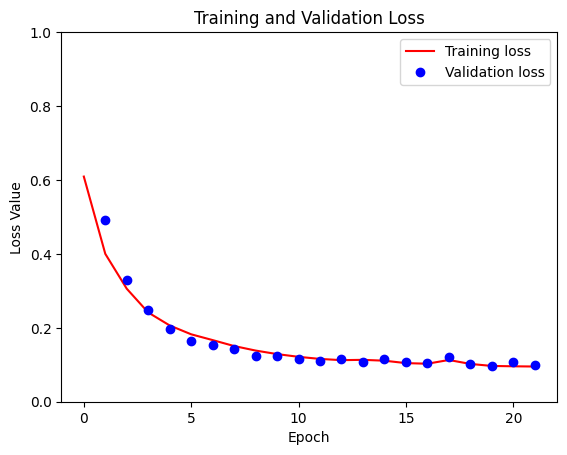

In [11]:
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

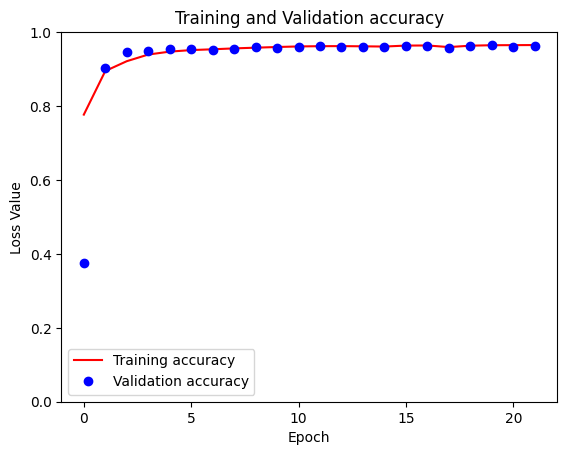

In [12]:
accuracy = model.history.history['accuracy']
val_accuracy = model.history.history['val_accuracy']

plt.figure()
plt.plot( accuracy, 'r', label='Training accuracy')
plt.plot( val_accuracy, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [14]:
import torch
torch.save(model, 'data/RESULT1_UNET/best_model_cree.pth') # permet de savoir quel epoch est la meilleur 
print('Model saved!')

INFO:tensorflow:Assets written to: ram://6fd2cab1-835a-457f-ba65-00fcc35458e5/assets


INFO:tensorflow:Assets written to: ram://6fd2cab1-835a-457f-ba65-00fcc35458e5/assets


Model saved!


In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [16]:
i = random.randint(0, len(X_test))
sample_image = X_test[i]
sample_mask = y_test[i]

In [17]:
prediction = model.predict(sample_image[tf.newaxis, ...])[0]

1/1 [==============================] - 0s 195ms/step


In [18]:
predicted_mask = (prediction > 0.5).astype(np.uint8)

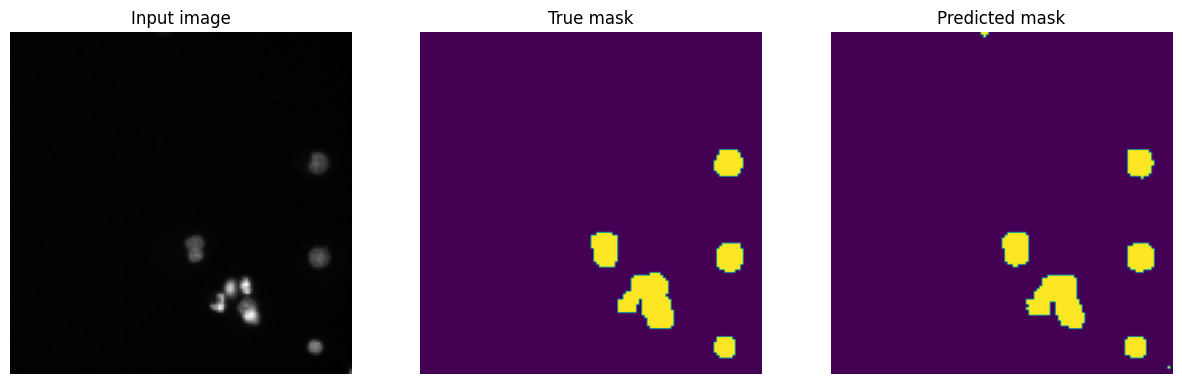

In [19]:
display([sample_image, sample_mask,predicted_mask])

In [23]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random
import os

def display_and_save(display_list, save_path):
    plt.figure(figsize=(15, 5))  # Réduire la hauteur de la figure pour mieux s'adapter
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    
    plt.savefig(save_path)  # Sauvegarder la figure
    plt.close()  # Fermer la figure pour éviter d'afficher trop de figures ouvertes

# Créer le chemin du dossier de sauvegarde si nécessaire
save_dir = "data/RESULT1_UNET/perf"  # Remplacer par le chemin du dossier où vous voulez sauvegarder les images
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Boucler sur toutes les images de test
for i in range(len(X_test)):
    sample_image = X_test[i]
    sample_mask = y_test[i]

    # Faire une prédiction sur l'image d'échantillon
    prediction = model.predict(sample_image[tf.newaxis, ...])[0]
    predicted_mask = (prediction > 0.5).astype(np.uint8)

    # Définir le chemin complet du fichier de sauvegarde
    save_path = os.path.join(save_dir, f'sample_{i}.png')

    # Afficher et sauvegarder l'image, le masque réel et le masque prédit
    display_and_save([sample_image, sample_mask, predicted_mask], save_path)


1/1 [==============================] - 0s 23ms/step
